# Flagging Inappropriate Content Using LSTMs in Keras:

## Project Summary:
Here is the code with all the steps needed for classifying comments to 3 categories: zero-tolerance, offensive, and fine using LSTM, you will need to provide your labelled data which is not included in this repository given the nature of the project.

In [1]:
#importing libraries
import sys, os, re, csv, codecs
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model

from nltk.corpus import stopwords

from keras import initializers, regularizers, constraints, optimizers, layers

### Loading the train dataset in colab:

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving all.csv to all.csv


In [ ]:
import io
data = pd.read_csv(io.BytesIO(uploaded['all.csv']))

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ONGO.csv to ONGO.csv


In [ ]:
import io
ongo_test = pd.read_csv(io.BytesIO(uploaded['ONGO.csv']))

## Loading data and GloVe:


In [ ]:
uploaded = files.upload()

In [ ]:
glove = uploaded['glove.6B.50d.txt']

In [ ]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [ ]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

Checking GloVe:

In [ ]:
word = "yoga"
idx = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

## Brief EDA
### Looking at the sample of the dataset:

In [ ]:
data[data['hate']==1].sample(5)

,text,hate,offensive,ok
74876,Halfway decent map of what? You stupid cock-su...,1,0,0
205356,don t call someone a fat ugly whore you guys h...,1,0,0
202628,suck my fuckin dick,1,0,0
77150,"FUCK YOU THUE \n\nYOU BRAIN DEAD FUCK, YOU CAN...",1,0,0
206445,r politics will come to your house and murder ...,1,0,0


In [ ]:
ongo_test.sample(5)

,text
6788,"Well done Jon - as Nate says, building a solid..."
9824,I am sooo sorry your IT band is screaming. You...
2742,Way to go Joe !! Love the video.\n
758,"Yep same here. Sore in same areas, I’ve notic..."
4096,question? How do you ensure that you don’t get...


Is there any null values in the datasets:

In [ ]:
data.dtypes

text         object
hate          int64
offensive     int64
ok            int64
dtype: object

In [ ]:
data.isnull().any()

text         False
hate         False
offensive    False
ok           False
dtype: bool

In [ ]:
ongo_test.isnull().any()

text    False
dtype: bool

In [ ]:
data = data.sample(frac=1)

Creating test dataset from the training dataset:

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(data, test_size=0.1, random_state=42)

In [ ]:
df_test.head(5)

,text,hate,offensive,ok
20150,RT @thecoreyholcomb: Long finger dike hoes be ...,0,1,0
89576,My edit is correct. See Talk:Madagascar: Escap...,0,0,1
123422,When the mood takes me I wank into a sock. It ...,0,1,0
62666,Unblock my talkpage now.,0,0,1
67104,Familicide==\nI just created a new page on Fam...,0,0,1


## Preparing data
Some cleaning on the dataset:

In [ ]:
def clean_text(text):
    """
    Clean the text 
    Arguments: text -- each comment
    Returns: lower case cleen text --each comment"""
    text = text.lower()
    text = re.sub(r"what's","what is", text)
    text = re.sub(r"rt", '',text)
    text = re.sub(r"\'ve","have", text)
    text = re.sub(r"can't","cannot",text)
    text = re.sub(r"n't", "not", text)
    text = re.sub(r"i'm","i am", text)
    text = re.sub(r"\'re'","are", text)
    text = re.sub(r"\'d'","would",text)
    text = re.sub(r"\'ll'", "will", text)
    text = re.sub(r"\'scuse'", "excuse", text)
    text = re.sub("\W",' ', text)
    text = re.sub('\s+',' ',text)
    text = text.strip(' ')
    return text
df_train['cmt'] = df_train['text'].map(lambda x: clean_text(x))
df_test['cmt'] = df_test['text'].map(lambda x: clean_text(x))
ongo_test['cmt'] = ongo_test['text'].map(lambda x: clean_text(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


There are 3 different columns on the dataset (hate, offensive, and ok). 
Here we are defining x and y:

In [ ]:
list_classes = ['hate','offensive','ok']
y = df_train[list_classes]
x = df_train['cmt']

In [ ]:
y_test = df_test[list_classes].values
x_test = df_test['cmt']

In [ ]:
x_ongo_test = ongo_test['cmt']

Tokenization (breaking down the sentence into unique words), Indexing (indexing each word eg), and Index Representation are all done using:

In [ ]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(x))
list_tokenized_x = tokenizer.texts_to_sequences(x)

list_tokenized_x_test = tokenizer.texts_to_sequences(x_test)

list_tokenized_x_ongo_test = tokenizer.texts_to_sequences(x_ongo_test)

If you need to download the tokenizer you can use the comments below (currently deactive):

In [ ]:

#tokenizer.word_counts
#tokenizer.word_index

In [ ]:
#import pickle
#pickle.dump(tokenizer,open("TK.pkl","wb"))

In [ ]:
#with open('TK.pkl','rb') as f:
#    TK = pickle.load(f)

In [ ]:
#print(TK.texts_to_sequences(x_test[1]))

In [ ]:
#from google.colab import files
#files.download("TK.pkl")

To just check how tokenizer works:

In [ ]:
x_test[:1]
print(list_tokenized_x[:1])


[[16606, 16606, 609, 1622, 36, 7508, 33, 28, 1302, 13, 8, 180, 44, 1, 5196, 83, 4, 20, 895, 199, 32, 29, 1162, 376, 7, 21, 179, 800, 7, 533, 78, 10, 814, 2, 8740, 1, 213, 61, 4, 196, 556, 184, 6, 1, 213, 61, 4, 92, 21, 2, 1487, 91, 17, 5, 960, 381, 10, 25, 6983, 4, 85, 363, 160, 8908, 146, 13, 2615, 2, 1487, 67, 85, 928, 722, 4, 806, 160, 16, 251, 2, 17097, 1, 1394, 11, 80, 1946, 44, 104, 6, 21, 191, 1357, 350, 9, 3, 25, 1692, 2888, 16607, 17, 1, 903, 87, 691, 43, 3, 332, 92, 25, 2347, 16607, 7, 91, 5, 960, 6, 181, 2, 1, 376, 9, 2360, 10, 276, 1409, 7, 960, 3248, 3477, 73, 22, 376, 8, 1121, 1576, 26, 1965, 559, 87, 9, 10, 47, 57, 1217, 2, 16, 377, 21, 600, 9353, 7, 9, 376, 2, 287, 6, 99, 10, 150, 44, 3, 25, 5, 1576, 1483, 8, 87, 5, 349, 7, 903, 928, 13, 359, 574, 123, 4, 2236, 10, 55, 59, 94, 16607, 18, 1877, 12, 21, 2325, 2596, 163]]


Doing some EDA on the data, I decided to limit the maximum length of comments to 200 words. To keep the length of all 200 I used padding:

In [ ]:
maxlen = 300

X_train = pad_sequences(list_tokenized_x, maxlen=maxlen,padding='post')
X_test = pad_sequences(list_tokenized_x_test, maxlen=maxlen,padding='post')
X_test_ongo = pad_sequences(list_tokenized_x_ongo_test,padding='post')

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_article(text):
 return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(X_train[2]))

To check the distribution of number of words in a sentence:

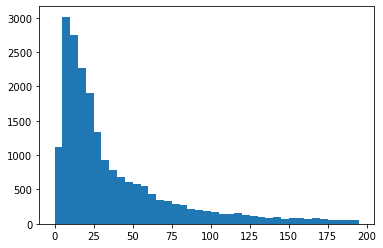

In [ ]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_x_test]
plt.hist(totalNumWords, bins= np.arange(0,200,5))
plt.show()

# Starting the model:

# Creating model
Here is the architecture of the model I used:
I used GloVe as the pretrained embedding.


In [ ]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = 50      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros.
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Step 2
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]


    # Step 3
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(vocab_len, emb_dim)#, trainable = False)
    ### END CODE HERE ###

    # Step 4 
    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) 
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [ ]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

In [ ]:
inp = Input(shape=(maxlen,))#max_len=200 as defined earlier

To just make sure that everything is fine yet:

In [ ]:
data.describe()

We pass the input to the embedding layer to define vectors, then it goes to the LSTM layer, then using Globalmaxpool to reduce dimenssion, then dense layer, dropout to deactivate some cells, again dense layer and dropout and dense layer:

In [ ]:
def LSTM_v2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the LSTM_v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary 

    Returns:
    model 
    """
    
    # It should be of shape input_shape and dtype 'int32'.
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through embedding layer
    embeddings = embedding_layer(sentence_indices)
    
    # Propagate the embeddings through a BLSTM layer with 128-dimensional hidden state
    X = Bidirectional(LSTM(128, return_sequences=True))(embeddings)
    # Add dropout
    X = Dropout(rate =  0.5)(X)
    X = Dense(50, activation="relu")(X)
    X = Bidirectional(LSTM(64, return_sequences=True))(X)
    X = GlobalMaxPool1D()(X)
    X = Dropout(rate =  0.5)(X)
    # Propagate X through a Dense layer with 5 units
    X = Dense(20, activation="relu")(X)
    X = Dropout(rate =  0.5)(X)
    X = Dense(units = 3, activation = 'softmax')(X)

    

    model = Model(sentence_indices,X)
    

    
    return model

Epoch 1/10
 262/4868 [>.............................] - ETA: 1:31 - loss: 0.4251 - accuracy: 0.7675

In [ ]:
model = LSTM_v2((maxlen,), word_to_vec_map, word_to_index)
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y, batch_size=32, epochs=10, validation_split=(0.2))

In [ ]:
#save a model
model.save('model.keras')
# Load a model
#model = keras.models.load_model('model.keras')


In [ ]:
from google.colab import files
files.download('model.keras')
#from google.colab import drive
#drive.mount('/content/gdrive')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show();

In [ ]:
model.summary()

In [ ]:
## Evaluating model performance and making predictions


In [ ]:
!pwd 

In [ ]:
from google.colab import files
files.download("model.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Prediction

In [ ]:
y_pred = model.predict([X_test], batch_size=1024,verbose=1)

22/22 [==============================] - 1s 32ms/step


In [ ]:
y_pred_ongo = model.predict([X_test_ongo], batch_size=1024,verbose=1)

11/11 [==============================] - 0s 43ms/step


In [ ]:
for i in range(len(y_pred_ongo)):
  if y_pred_ongo[i][0]>0.98:
    print(x_ongo_test[i])

In [ ]:
x_ongo_test[10499]

'it is an ass kicker indeed'

In [ ]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
matrix

In [ ]:
metrics.accuracy_score(y_test, y_pred.round(), normalize=True)

0.9296875

In [ ]:
  for i in range(len(y_pred)):
        max_value=max(y_pred[i])
        for j in range(len(y_pred[i])):
            if max_value==y_pred[i][j]:
                y_pred[i][j]=1
            else:
                y_pred[i][j]=0

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
print(classification_report(y_test, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.8622    0.7208    0.7852      2378
           1     0.8550    0.7555    0.8022      2638
           2     0.9673    0.9872    0.9771     16963

   micro avg     0.9455    0.9306    0.9380     21979
   macro avg     0.8948    0.8212    0.8548     21979
weighted avg     0.9424    0.9306    0.9354     21979
 samples avg     0.9455    0.9376    0.9402     21979



Here the thereshhold can be modified based on the need

In [ ]:
"""for i in range(len(y_pred)):
    max_value=max(y_pred[i])
        if y_pred[i][0] == max_value and max_value>0.7:
          y_pred[i][0]=1
          y_pred[i][1]=0
          y_pred[i][2]=0
        elif max_value<0.7:
          if y_pred[i][0] + y_pred[i][1] > 0.5:
            y_pred[i][1]=1
            y_pred[i][0]=0
            y_pred[i][2]=0
          else:
            y_pred[i][1]=0
            y_pred[i][0]=0
            y_pred[i][2]=1
        else:
            y_pred[i][1]=0
            y_pred[i][0]=0
            y_pred[i][2]=1         

"""